In [72]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate as spinter, optimize as spopt
from delta_method import delta_method, parametric_bootstrap
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
np.set_printoptions(threshold=sys.maxsize)

In [73]:
###### FUNCTIONS #########

def read_metadata(requested_data): #DO NOT OPEN MULTIPLE SHEETS AT ONCE. OPEN THE SHOT SHEET AND TARGET SHEET SEPERATELY!
    shot_list = ["SHOT #","Date","Time","Purpose","Target X","Target Y","Target Z","Wheel XPS","position on wheel","TARGET NUMBER","Laser Energy (before comp) [J]","Laser duration [fs]","Horiz ns/div","Trigger val [mV]","C1 [V/div]","C2 [V/div]","C3 [V/div]","C4 [V/div]","C1 att [dB]","C2 att [dB]","C3 att [dB]","C1 diag","C2 diag","C3 diag","C4 diag","Comments JLD scope","THz comments","Column2","X-ray comments","Column3","Column4","Column5"]
    target_list = ["Date","Number","Position in the box","Wheel","Position on the wheel","Rotation angle(TARGET)","XYZ (TARGET)","Thickness (um)","Length(mm)","Material","Type","Comments"]

    if requested_data[0] in shot_list : sheet, header_row = "Shot-list", 1 # weird python syntax
    if requested_data[0] in target_list : sheet, header_row = "Target list", 0

    dataframe = pd.read_excel(io= "organised_data\\Shots_Targets_Diagnostics.xlsx", # numpy is bad at reading excel files.
                              sheet_name= sheet,
                              header= header_row,
                              usecols= requested_data)
    
    dictionary = dataframe.to_dict(orient= "list")
    return dictionary

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4))
                 for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def open_emp_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    column = emp_oscilloscope_data.index(requested_data)
    regex_code = "(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    emp_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =18, usecols= column))
                for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, emp_data

def read_diagnostic_data(requested_data, function= lambda x:x , silent= False): #Currently supports the pyro oscilloscope and the emp oscilloscope. Doesn't support target photos, espec, xray cam, focal spot cam and pyrocams. 
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_oscilloscope_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up regex.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope_data:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        elif request in emp_oscilloscope_data:
            new_shots, new_data = open_emp_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # Add the new data to it's respective shot.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [74]:
jean_lucs = pd.read_table("jean-lucs_emp_calculations.txt",
                          encoding= "utf_8",
                          encoding_errors= "ignore", # I don't know which encoding to use for '¡' so I will ignore it for now.
                          dtype= {"n shot": int,
                                  "Emp energy inside the chamber (J)": float},
                          decimal= ",") # continental format
jean_lucs = jean_lucs.to_dict(orient= "list")

In [75]:
shots = jean_lucs["n shot"]
requested_data = {"bdot": shots}

emp = read_diagnostic_data(requested_data, function= np.ptp, silent= False)

Found 217 files:
   s04_ALL.csv
   s05_ALL.csv
   s06_ALL.csv
   s07_ALL.csv
   s08_ALL.csv
   s09_ALL.csv
   s10_ALL.csv
   s11_ALL.csv
   s12_ALL.csv
   s13_ALL.csv
   s15_ALL.csv
   S16_ALL.csv
   S17_ALL.csv
   S18_ALL.csv
   S19_ALL.csv
   S20_ALL.csv
   s21_ALL.csv
   s36_ALL.csv
   s37_ALL.csv
   s38_ALL.csv
   s41_ALL.csv
   s42_ALL.csv
   s47_ALL.csv
   s49_ALL.csv
   s34_ALL.csv
   s52_ALL.csv
   s53_ALL.csv
   s60_ALL.csv
   s61_ALL.csv
   s66_ALL.csv
   s67_ALL.csv
   s69_ALL.csv
   s70_ALL.csv
   s71_ALL.csv
   s72_ALL.csv
   s74_ALL.csv
   s75_ALL.csv
   s77_ALL.csv
   s78_ALL.csv
   s79_ALL.csv
   s80_ALL.csv
   s82_ALL.csv
   s83_ALL.csv
   s84_ALL.csv
   s85_ALL.csv
   s86_ALL.csv
   s87_ALL.csv
   s88_ALL.csv
   s89_ALL.csv
   s91_ALL.csv
   s92_ALL.csv
   s93_ALL.csv
   s94_ALL.csv
   s95_ALL.csv
   s96_ALL.csv
   s97_ALL.csv
   s98_ALL.csv
   s100_ALL.csv
   s101_ALL.csv
   s102_ALL.csv
   s103_ALL.csv
   s104_ALL.csv
   S105_ALL.csv
   s106_ALL.csv
   s99_ALL.csv
 

In [76]:
overlapping_shots, count = np.unique([*emp["shot"], *shots], return_counts= True)

overlapping_shots[np.nonzero(count != 2)]

array([234])

In [77]:
emp["shot"].append(234)
emp["bdot"].append(np.nan)

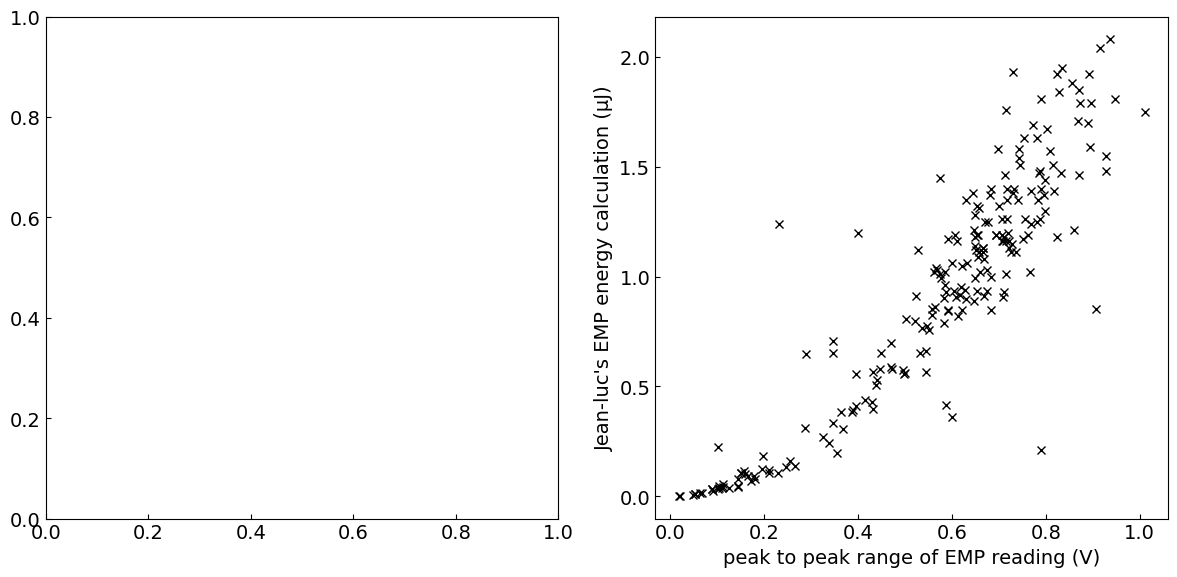

In [81]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

line1, = axs[0].plot(jean_lucs["n shot"],
                    np.array(jean_lucs["Emp energy inside the chamber (J)"]) *1e6,
                    linestyle= "None",
                    marker= "o",
                    color= "tab:blue",
                    label= "EMP energy")
axs[0].set(xlabel= "Shot number", ylabel= "Jean-luc's energy (μJ)")

twinaxs = axs[0].twinx()
line2, = twinaxs.plot(emp["shot"],
                     emp["bdot"],
                     linestyle= "None",
                     marker= "^",
                     color= "tab:red",
                     label= "peak to peak voltage")
twinaxs.set(ylabel= "EMP voltage (V)")
plt.legend(handles= [line1, line2])



axs[1].plot(emp["bdot"],
         np.array(jean_lucs["Emp energy inside the chamber (J)"]) *1e6,
         linestyle= "None",
         marker= "x",
         color= "k")

axs[1].set(xlabel= "peak to peak range of EMP reading (V)", ylabel= "Jean-luc's EMP energy calculation (μJ)")

plt.tight_layout()
plt.show()